In [1]:
# If needed, uncomment to install deps
# !pip install -q transformers timm tifffile

import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import tifffile as tiff
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import SegformerForSemanticSegmentation

# Colab: mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/drive/MyDrive/Dataset/Dataset.zip"
extract_dir = "/content/Dataset"   # where you want to unzip

# Make sure output dir exists
os.makedirs(extract_dir, exist_ok=True)

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Dataset extracted to: {extract_dir}")

# Paths after extraction
images_path = os.path.join(extract_dir, "Image")
masks_path  = os.path.join(extract_dir, "Mask")
swir_path = os.path.join(extract_dir, "SWIR")
dem_path = os.path.join(extract_dir, "DEM")
build_path = os.path.join(extract_dir, "Build")
# Quick check
print("\nSample files:")
print("Images:", os.listdir(images_path)[:5])
print("Masks:", os.listdir(masks_path)[:5])
print("Swir:", os.listdir(swir_path)[:5])
print("Dem:", os.listdir(dem_path)[:5])
print("Build-up:", os.listdir(build_path)[:5])


✅ Dataset extracted to: /content/Dataset

Sample files:
Images: ['Image_1001.tif', 'Image_0950.tif', 'Image_0019.tif', 'Image_0313.tif', 'Image_0943.tif']
Masks: ['Mask_0080.tif', 'Mask_0366.tif', 'Mask_0539.tif', 'Mask_0312.tif', 'Mask_0743.tif']
Swir: ['Swir_0142.tif', 'Swir_0539.tif', 'Swir_0540.tif', 'Swir_0646.tif', 'Swir_0836.tif']
Dem: ['Dem_0109.tif', 'Dem_0453.tif', 'Dem_0915.tif', 'Dem_0504.tif', 'Dem_0560.tif']
Build-up: ['built_1005.tif', 'built_0353.tif', 'built_0277.tif', 'built_1010.tif', 'built_1033.tif']


In [40]:
# ================================
# Multimodal Segmentation Dataset (RGB + SWIR + DEM + BUILD + MASK)
# Now supports 4 non-overlapping crops of 256×256 from each image.
# ================================
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import tifffile as tiff

class MultiModalSegDataset(Dataset):
    def __init__(self, images_dir, swir_dir, dem_dir, build_dir, masks_dir,
                 crop_size=256, num_classes=5, normalize=True):
        self.images_dir = images_dir
        self.swir_dir   = swir_dir
        self.dem_dir    = dem_dir
        self.build_dir  = build_dir
        self.masks_dir  = masks_dir
        self.crop_size  = crop_size
        self.num_classes = num_classes
        self.normalize  = normalize

        # File lists
        self.image_files = sorted(os.listdir(images_dir))
        self.swir_files  = sorted(os.listdir(swir_dir))
        self.dem_files   = sorted(os.listdir(dem_dir))
        self.build_files = sorted(os.listdir(build_dir))
        self.mask_files  = sorted(os.listdir(masks_dir))

        assert len(self.image_files) == len(self.swir_files) == len(self.dem_files) == len(self.build_files) == len(self.mask_files), \
            "❌ File count mismatch between modalities."

        # Store crop index for 4 crops per image
        self.samples = []
        for idx in range(len(self.image_files)):
            for crop_idx in range(4):  # 4 crops per image
                self.samples.append((idx, crop_idx))

        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        self.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    def __len__(self):
        return len(self.samples)

    def _read_tiff_or_img(self, path):
        if path.lower().endswith(('.tif', '.tiff')):
            return tiff.imread(path)
        else:
            return np.array(Image.open(path))

    def _normalize_to_01(self, arr):
        arr = arr.astype(np.float32)
        return (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr) + 1e-8)

    def _read_rgb(self, path):
        img = self._read_tiff_or_img(path)
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        elif img.ndim == 3 and img.shape[0] == 3:
            img = np.transpose(img, (1,2,0))
        img = self._normalize_to_01(img)
        return img

    def _read_swir(self, path):
        swir = self._read_tiff_or_img(path)
        if swir.ndim == 2:
            swir = np.expand_dims(swir, axis=-1)
        if swir.ndim == 3 and swir.shape[-1] > 3:
            swir = swir[..., :3]
        swir = self._normalize_to_01(swir)
        return np.transpose(swir, (2,0,1))

    def _read_single(self, path):
        arr = self._read_tiff_or_img(path)
        arr = np.squeeze(arr)
        arr = self._normalize_to_01(arr)
        return np.expand_dims(arr, axis=0)

    def _read_mask(self, path):
        mask = self._read_tiff_or_img(path)
        if mask.ndim == 3:
            mask = mask[:,:,0]
        return mask.astype(np.int64)

    def _get_crop_coords(self, H, W, crop_idx):
        """4 non-overlapping crops (2×2 grid)."""
        half_H = H // 2
        half_W = W // 2
        if crop_idx == 0:  # top-left
            return 0, 0
        elif crop_idx == 1:  # top-right
            return 0, W - self.crop_size
        elif crop_idx == 2:  # bottom-left
            return H - self.crop_size, 0
        else:  # bottom-right
            return H - self.crop_size, W - self.crop_size

    def __getitem__(self, index):
        img_idx, crop_idx = self.samples[index]

        img_path   = os.path.join(self.images_dir, self.image_files[img_idx])
        swir_path  = os.path.join(self.swir_dir,   self.swir_files[img_idx])
        dem_path   = os.path.join(self.dem_dir,    self.dem_files[img_idx])
        build_path = os.path.join(self.build_dir,  self.build_files[img_idx])
        mask_path  = os.path.join(self.masks_dir,  self.mask_files[img_idx])

        image = self._read_rgb(img_path)      # (H, W, 3)
        swir  = self._read_swir(swir_path)    # (3, H, W)
        dem   = self._read_single(dem_path)   # (1, H, W)
        build = self._read_single(build_path) # (1, H, W)
        mask  = self._read_mask(mask_path)    # (H, W)

        # Ensure shapes match before cropping
        H, W = mask.shape
        top, left = self._get_crop_coords(H, W, crop_idx)
        bottom, right = top + self.crop_size, left + self.crop_size

        # Crop consistently
        image = np.transpose(image, (2,0,1))[:, top:bottom, left:right]
        swir  = swir[:, top:bottom, left:right]
        dem   = dem[:, top:bottom, left:right]
        build = build[:, top:bottom, left:right]
        mask  = mask[top:bottom, left:right]

        # Normalize RGB
        if self.normalize:
            for c in range(3):
                image[c] = (image[c] - self.mean[c]) / self.std[c]

        # Convert to torch
        image = torch.tensor(image, dtype=torch.float32)
        swir  = torch.tensor(swir, dtype=torch.float32)
        dem   = torch.tensor(dem, dtype=torch.float32)
        build = torch.tensor(build, dtype=torch.float32)
        mask  = torch.tensor(mask, dtype=torch.long)
        mask[mask >= self.num_classes] = self.num_classes - 1

        return image, swir, dem, build, mask


In [41]:
# ================================
# Quick Test
# ================================
IMAGES_DIR = "/content/Dataset/Image"   # FCC
MASKS_DIR  = "/content/Dataset/Mask"
SWIR_DIR   = "/content/Dataset/SWIR"
DEM_DIR    = "/content/Dataset/DEM"
BUILD_DIR  = "/content/Dataset/Build"

full_dataset = MultiModalSegDataset(
    images_dir=IMAGES_DIR,
    swir_dir=SWIR_DIR,
    dem_dir=DEM_DIR,
    build_dir=BUILD_DIR,
    masks_dir=MASKS_DIR,
    crop_size=256,       # ✅ this defines your 256×256 crops
    num_classes=5,       # ✅ number of segmentation classes
    normalize=True       # ✅ optional normalization
)


print("✅ Dataset loaded successfully!")
print("Total samples:", len(full_dataset))

# ---- Load first sample ----
image, swir, dem, build, mask = full_dataset[0]

print("RGB shape:", image.shape)     # Expected [3, 256, 256]
print("SWIR shape:", swir.shape)     # Expected [3, 256, 256]
print("DEM shape:", dem.shape)       # Expected [1, 256, 256]
print("Build shape:", build.shape)   # Expected [1, 256, 256]
print("Mask shape:", mask.shape)     # Expected [256, 256])


✅ Dataset loaded successfully!
Total samples: 4296
RGB shape: torch.Size([3, 256, 256])
SWIR shape: torch.Size([3, 256, 256])
DEM shape: torch.Size([1, 256, 256])
Build shape: torch.Size([1, 256, 256])
Mask shape: torch.Size([256, 256])


In [55]:
# ================================
# Step 2: Train/Validation Split + DataLoaders
# ================================
from torch.utils.data import random_split, DataLoader
import torch

# Fix random seed for reproducibility
seed = 42
torch.manual_seed(seed)

# -------------------------------
# Split dataset (80% train, 20% validation)
# -------------------------------
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

# -------------------------------
# DataLoader parameters
# -------------------------------
BATCH_SIZE  = 1
NUM_WORKERS = 2  # adjust based on your CPU cores

def multimodal_collate_fn(batch):
    """
    Custom collate function for multimodal data:
    (image, swir, dem, build, mask)
    """
    image_batch = torch.stack([item[0] for item in batch])  # [B, 3, H, W]
    swir_batch  = torch.stack([item[1] for item in batch])  # [B, 3, H, W]
    dem_batch   = torch.stack([item[2] for item in batch])  # [B, 1, H, W]
    build_batch = torch.stack([item[3] for item in batch])  # [B, 1, H, W]
    mask_batch  = torch.stack([item[4] for item in batch])  # [B, H, W]

    return image_batch, swir_batch, dem_batch, build_batch, mask_batch


# -------------------------------
# Create DataLoaders
# -------------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=multimodal_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=multimodal_collate_fn
)

# -------------------------------
# Quick sanity check for batch shapes
# -------------------------------
image_b, swir_b, dem_b, build_b, mask_b = next(iter(train_loader))
print(f"✅ Train batch shapes:")
print(f"   Image (FCC): {tuple(image_b.shape)}")   # [B, 3, H, W]
print(f"   SWIR:        {tuple(swir_b.shape)}")    # [B, 3, H, W]
print(f"   DEM:         {tuple(dem_b.shape)}")     # [B, 1, H, W]
print(f"   Build-up:    {tuple(build_b.shape)}")   # [B, 1, H, W]
print(f"   Mask:        {tuple(mask_b.shape)}")    # [B, H, W]

# Optional channel consistency check
assert image_b.shape[1] == full_dataset[0][0].shape[0], \
    f"Channel mismatch! Expected {full_dataset[0][0].shape[0]}, got {image_b.shape[1]}"


✅ Train batch shapes:
   Image (FCC): (1, 3, 256, 256)
   SWIR:        (1, 3, 256, 256)
   DEM:         (1, 1, 256, 256)
   Build-up:    (1, 1, 256, 256)
   Mask:        (1, 256, 256)


cheching the sequence

In [56]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=25,
                      #  border_mode=0, interpolation=1, p=0.7),  # interpolation=1 = NEAREST
    # A.RandomBrightnessContrast(p=0.5),
    # A.GaussianBlur(p=0.3),
    # A.ElasticTransform(p=0.2),
])


In [64]:
# ==========================================================
# MultiModal SegFormer (shared SegFormer-B2 encoder)
# Mid-level Cross-Attention Fusion + Attention Upsampling
# Uses lightweight projection heads for SWIR/DEM/BUILD
# ==========================================================
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import SegformerModel


# --------------------------
# Helpers
# --------------------------
def tokens_to_map(x):
    """
    Convert transformer token output (B, N, C) to map (B, C, H, W),
    assuming tokens are arranged as square grid.
    """
    if x.ndim == 3:
        B, N, C = x.shape
        H = W = int(math.sqrt(N))
        return x.transpose(1, 2).reshape(B, C, H, W)
    elif x.ndim == 4:
        return x
    else:
        raise ValueError("Unexpected feature shape: ", x.shape)


# --------------------------
# Cross-Attention Fusion Block
# --------------------------
class CrossAttentionFusion(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.attn_swir = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads)
        self.attn_dem = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads)
        self.attn_build = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads)
        self.alpha = nn.Parameter(torch.tensor([0.33, 0.33, 0.33], dtype=torch.float32))
        self.norm = nn.LayerNorm(dim)

    def forward(self, fcc_map, swir_map, dem_map, build_map):
        """
        inputs: all [B, C, H, W] where C == dim
        returns: fused [B, C, H, W]
        """
        B, C, H, W = fcc_map.shape

        # flatten to (seq_len, batch, embed)
        q = fcc_map.flatten(2).permute(2, 0, 1)      # [HW, B, C]
        k_s = swir_map.flatten(2).permute(2, 0, 1)
        k_d = dem_map.flatten(2).permute(2, 0, 1)
        k_b = build_map.flatten(2).permute(2, 0, 1)

        f_swir, _ = self.attn_swir(q, k_s, k_s)
        f_dem, _ = self.attn_dem(q, k_d, k_d)
        f_build, _ = self.attn_build(q, k_b, k_b)

        fused = q + self.alpha[0] * f_swir + self.alpha[1] * f_dem + self.alpha[2] * f_build
        fused = self.norm(fused)                      # [HW, B, C]
        fused = fused.permute(1, 2, 0).view(B, C, H, W)  # [B, C, H, W]
        return fused


# --------------------------
# Attention Upsample (transformer-style)
# --------------------------
class AttentionUpsample(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads)
        self.norm = nn.LayerNorm(dim)

    def forward(self, low, high):
        """
        low:   [B, C, H_low, W_low]  (semantic, lower resolution)
        high:  [B, C, H_high, W_high] (skip / higher resolution)
        returns: fused [B, C, H_high, W_high]
        """
        B, C, Hh, Wh = high.shape
        low_resized = F.interpolate(low, size=(Hh, Wh), mode="bilinear", align_corners=False)

        low_flat = low_resized.flatten(2).permute(2, 0, 1)   # [Hh*Wh, B, C]
        high_flat = high.flatten(2).permute(2, 0, 1)         # [Hh*Wh, B, C]

        attn_out, _ = self.attn(query=high_flat, key=low_flat, value=low_flat)
        fused = self.norm(high_flat + attn_out)
        fused = fused.permute(1, 2, 0).view(B, C, Hh, Wh)
        return fused


# --------------------------
# Main model: shared encoder
# --------------------------
class MultiModalSegFormerShared(nn.Module):
    def __init__(self, num_classes=5, decoder_dim=512, attn_heads=8):
        super().__init__()

        # single shared SegFormer-B2 encoder
        self.encoder = SegformerModel.from_pretrained(
            "nvidia/segformer-b2-finetuned-ade-512-512",
            output_hidden_states=True
        )
        embed_dims = self.encoder.config.hidden_sizes  # e.g. [64,128,320,512]

        # lightweight projection heads for each modality per scale
        # these map modality input (3 or 1 channels) -> embed_dim[channel]
        def make_proj(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        # SWIR projections for c1,c2,c3
        self.swir_proj = nn.ModuleList([make_proj(3, d) for d in embed_dims[:3]])
        # DEM projections
        self.dem_proj  = nn.ModuleList([make_proj(1, d) for d in embed_dims[:3]])
        # BUILD projections
        self.build_proj = nn.ModuleList([make_proj(1, d) for d in embed_dims[:3]])

        # Cross-attention fusion per level
        self.cross1 = CrossAttentionFusion(dim=embed_dims[0], num_heads=attn_heads)
        self.cross2 = CrossAttentionFusion(dim=embed_dims[1], num_heads=attn_heads)
        self.cross3 = CrossAttentionFusion(dim=embed_dims[2], num_heads=attn_heads)

        # Linear projections to decoder_dim
        self.linear_c1 = nn.Conv2d(embed_dims[0], decoder_dim, kernel_size=1)
        self.linear_c2 = nn.Conv2d(embed_dims[1], decoder_dim, kernel_size=1)
        self.linear_c3 = nn.Conv2d(embed_dims[2], decoder_dim, kernel_size=1)
        self.linear_c4 = nn.Conv2d(embed_dims[3], decoder_dim, kernel_size=1)

        # Attention upsampling decoder
        self.attn_up3 = AttentionUpsample(decoder_dim, num_heads=attn_heads)
        self.attn_up2 = AttentionUpsample(decoder_dim, num_heads=attn_heads)
        self.attn_up1 = AttentionUpsample(decoder_dim, num_heads=attn_heads)

        self.dropout = nn.Dropout2d(0.1)
        self.classifier = nn.Conv2d(decoder_dim, num_classes, kernel_size=1)

    def forward(self, fcc, swir, dem, build):
        """
        fcc:  [B, 3, H, W]
        swir: [B, 3, H, W]
        dem:  [B, 1, H, W]
        build:[B, 1, H, W]
        """
        # 1) Shared encoder (extract multi-scale token outputs)
        enc_out = self.encoder(pixel_values=fcc, return_dict=True)
        hidden_states = enc_out.hidden_states  # tuple of 4: each (B, N, C)

        # convert tokens -> maps [B, C, H_i, W_i]
        c1_map = tokens_to_map(hidden_states[0])  # shallow, high-res
        c2_map = tokens_to_map(hidden_states[1])
        c3_map = tokens_to_map(hidden_states[2])
        c4_map = tokens_to_map(hidden_states[3])  # deepest, low-res

        # sizes for interpolation targets
        size1 = (c1_map.shape[2], c1_map.shape[3])
        size2 = (c2_map.shape[2], c2_map.shape[3])
        size3 = (c3_map.shape[2], c3_map.shape[3])

        # 2) Project each auxiliary modality to each scale, then resize to match encoder maps
        swir_feats = []
        dem_feats = []
        build_feats = []

        for i, proj in enumerate(self.swir_proj):
            feat = proj(swir)                      # [B, embed_dim_i, H, W]
            feat = F.interpolate(feat, size=(size1 if i==0 else (size2 if i==1 else size3)), mode="bilinear", align_corners=False)
            swir_feats.append(feat)

        for i, proj in enumerate(self.dem_proj):
            feat = proj(dem)
            feat = F.interpolate(feat, size=(size1 if i==0 else (size2 if i==1 else size3)), mode="bilinear", align_corners=False)
            dem_feats.append(feat)

        for i, proj in enumerate(self.build_proj):
            feat = proj(build)
            feat = F.interpolate(feat, size=(size1 if i==0 else (size2 if i==1 else size3)), mode="bilinear", align_corners=False)
            build_feats.append(feat)

        # 3) Multi-level cross-attention fusion (fuse aux into FCC features)
        c1_fused = self.cross1(c1_map, swir_feats[0], dem_feats[0], build_feats[0])
        c2_fused = self.cross2(c2_map, swir_feats[1], dem_feats[1], build_feats[1])
        c3_fused = self.cross3(c3_map, swir_feats[2], dem_feats[2], build_feats[2])

        # 4) Project to decoder dim
        p1 = self.linear_c1(c1_fused)
        p2 = self.linear_c2(c2_fused)
        p3 = self.linear_c3(c3_fused)
        p4 = self.linear_c4(c4_map)

        # 5) Attention-based decoding (cross-scale)
        x = self.attn_up3(p4, p3)   # combine c4->c3
        x = self.attn_up2(x, p2)    # combine -> c2
        x = self.attn_up1(x, p1)    # combine -> c1

        # 6) classifier
        x = self.dropout(x)
        logits = self.classifier(x)
        logits = F.interpolate(logits, size=fcc.shape[2:], mode="bilinear", align_corners=False)
        return logits


In [67]:
# ==========================================================
# Safe Inference for MultiModalSegFormer (SegFormer-B0)
# ==========================================================
import torch, gc
import torch.nn.functional as F

# ----------------------------------------------------------
# 1️⃣  Clean up GPU memory
# ----------------------------------------------------------
gc.collect()
torch.cuda.empty_cache()

# ----------------------------------------------------------
# 2️⃣  Device setup
# ----------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🟢 Using device: {device}")

# Move model to device and ensure it’s in eval mode (float32)
model = MultiModalSegFormerShared(num_classes=5, decoder_dim=256)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

model.eval()

# ----------------------------------------------------------
# 3️⃣  Get one small batch from DataLoader
# ----------------------------------------------------------
fcc, swir, dem, build, mask = next(iter(train_loader))

# Move data to GPU, keep float32
fcc   = fcc[:1].to(device).float()      # [1, 3, H, W]
swir  = swir[:1].to(device).float()     # [1, 3, H, W]
dem   = dem[:1].to(device).float()      # [1, 1, H, W]
build = build[:1].to(device).float()    # [1, 1, H, W]
mask  = mask[:1].to(device)

print(f"FCC:   {fcc.shape}")
print(f"SWIR:  {swir.shape}")
print(f"DEM:   {dem.shape}")
print(f"BUILD: {build.shape}")
print(f"MASK:  {mask.shape}")



🟢 Using device: cuda
FCC:   torch.Size([1, 3, 256, 256])
SWIR:  torch.Size([1, 3, 256, 256])
DEM:   torch.Size([1, 1, 256, 256])
BUILD: torch.Size([1, 1, 256, 256])
MASK:  torch.Size([1, 256, 256])


In [68]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# id2label = {0:"Urban", 1:"Water", 2:"Vegetation", 3:"Others"}
# label2id = {v:k for k,v in id2label.items()}

# model = SegformerForSemanticSegmentation.from_pretrained(
#     "nvidia/segformer-b0-finetuned-ade-512-512",
#     num_labels=4,
#     id2label=id2label,
#     label2id=label2id,
#     ignore_mismatched_sizes=True,  # new head (4 classes) initialized
# )
model.to(device)

# Optim & training settings
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
num_epochs = 10


to check augmentation

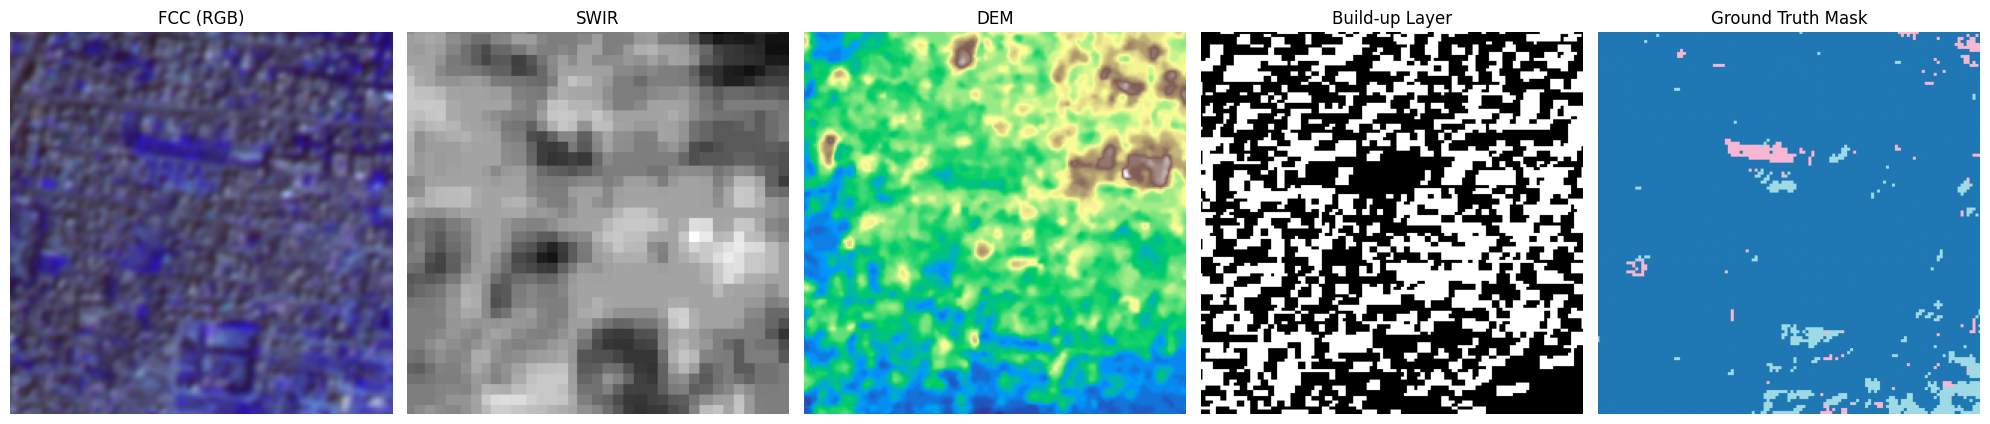

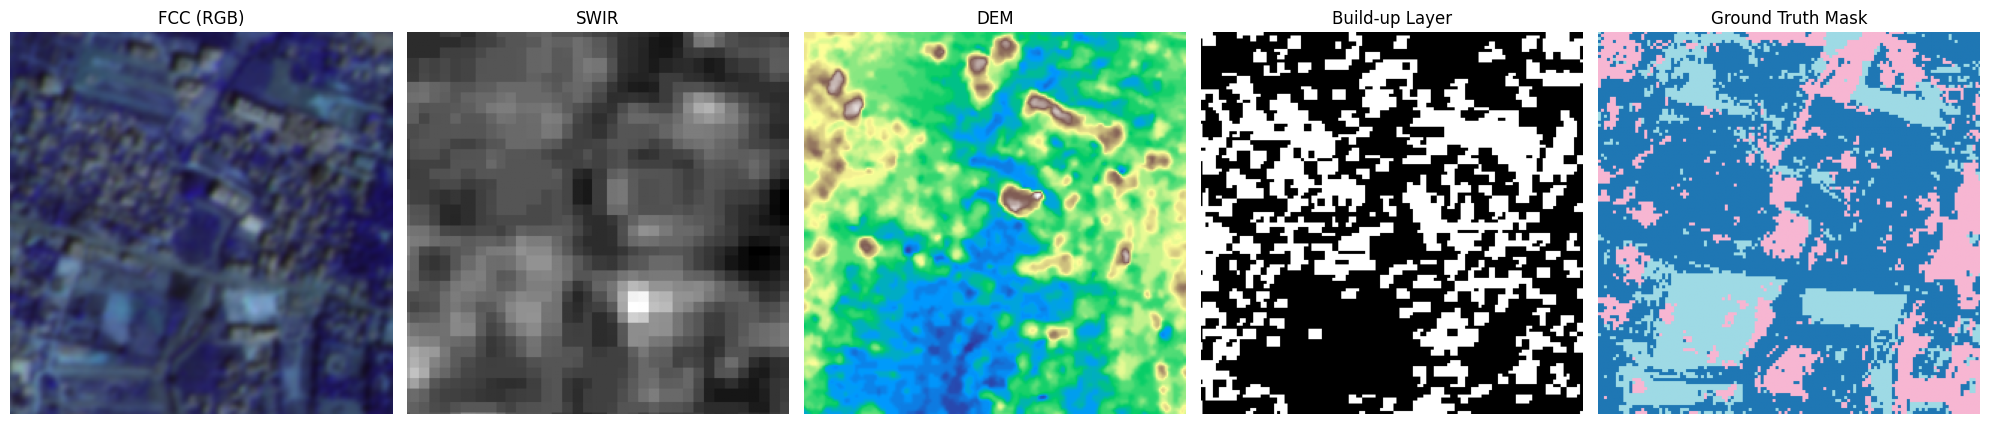

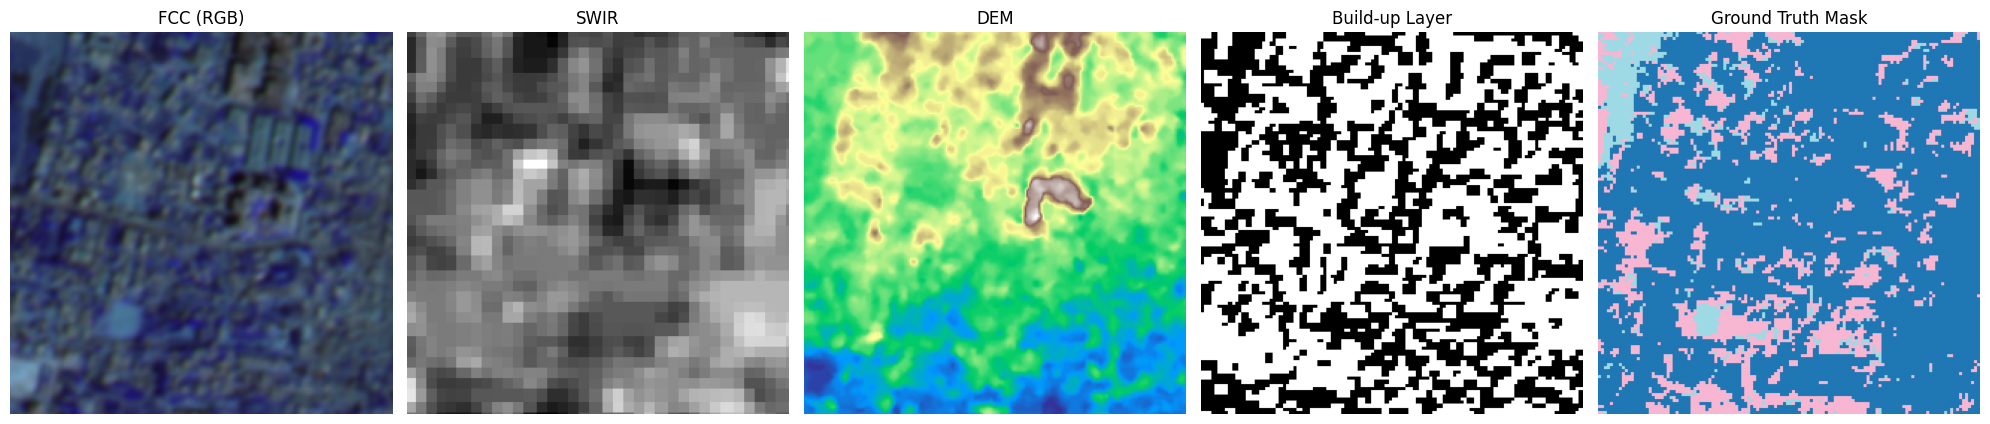

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Randomly visualize a few samples from your multimodal dataset
for i in range(3):
    # ----------------------------------------------------------
    # 1️⃣  Get random sample (fcc, swir, dem, build, mask)
    # ----------------------------------------------------------
    fcc, swir, dem, build, mask = train_dataset[np.random.randint(len(train_dataset))]

    # Convert to NumPy for visualization
    fcc_np   = fcc.numpy().transpose(1, 2, 0)    # [H, W, 3]
    swir_np  = swir.numpy().transpose(1, 2, 0)   # [H, W, C]
    dem_np   = dem.squeeze().numpy()             # [H, W]
    build_np = build.squeeze().numpy()           # [H, W]
    mask_np  = mask.numpy()                      # [H, W]

    # ----------------------------------------------------------
    # 2️⃣  Undo normalization for FCC (RGB)
    # ----------------------------------------------------------
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    fcc_vis = (fcc_np * std) + mean
    fcc_vis = np.clip(fcc_vis, 0, 1)

    # ----------------------------------------------------------
    # 3️⃣  Prepare SWIR visualization
    # ----------------------------------------------------------
    if swir_np.shape[2] > 1:
        swir_vis = swir_np[:, :, 0]  # Take first SWIR band
    else:
        swir_vis = swir_np.squeeze()

    # ----------------------------------------------------------
    # 4️⃣  Plot all modalities side-by-side
    # ----------------------------------------------------------
    plt.figure(figsize=(20, 5))

    # FCC (RGB)
    plt.subplot(1, 5, 1)
    plt.imshow(fcc_vis)
    plt.title("FCC (RGB)")
    plt.axis("off")

    # SWIR
    plt.subplot(1, 5, 2)
    plt.imshow(swir_vis, cmap="gray")
    plt.title("SWIR")
    plt.axis("off")

    # DEM
    plt.subplot(1, 5, 3)
    plt.imshow(dem_np, cmap="terrain")
    plt.title("DEM")
    plt.axis("off")

    # Build-up
    plt.subplot(1, 5, 4)
    plt.imshow(build_np, cmap="gray")
    plt.title("Build-up Layer")
    plt.axis("off")

    # Mask
    plt.subplot(1, 5, 5)
    plt.imshow(mask_np, cmap="tab20")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [70]:
import torch
import numpy as np

# ==========================================================
# Pixel Accuracy
# ==========================================================
def pixel_accuracy(preds: torch.Tensor, labels: torch.Tensor) -> float:
    """
    Compute pixel-wise accuracy.
    Works for both single image and batched tensors.

    Args:
        preds:  [B, H, W] or [H, W] tensor of predicted class IDs
        labels: [B, H, W] or [H, W] tensor of ground truth class IDs
    Returns:
        float: overall pixel accuracy (0–1)
    """
    preds = preds.detach()
    labels = labels.detach()

    # Ensure shape compatibility
    assert preds.shape == labels.shape, f"Shape mismatch: {preds.shape} vs {labels.shape}"

    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total


# ==========================================================
# Mean IoU (mIoU)
# ==========================================================
def mean_iou(preds: torch.Tensor, labels: torch.Tensor, num_classes: int = 5):
    """
    Compute mean Intersection-over-Union (mIoU) and per-class IoU.

    Args:
        preds: [B, H, W] predicted class IDs
        labels: [B, H, W] ground truth class IDs
        num_classes: total number of segmentation classes

    Returns:
        tuple: (mean_iou, per_class_iou)
    """
    preds = preds.detach()
    labels = labels.detach()

    assert preds.shape == labels.shape, f"Shape mismatch: {preds.shape} vs {labels.shape}"

    ious = []
    for cls in range(num_classes):
        pred_mask = (preds == cls)
        label_mask = (labels == cls)

        intersection = torch.logical_and(pred_mask, label_mask).sum().item()
        union = torch.logical_or(pred_mask, label_mask).sum().item()

        if union == 0:
            ious.append(float("nan"))  # Class absent in batch
        else:
            ious.append(intersection / union)

    mean_iou_val = np.nanmean(ious)
    return mean_iou_val, ious


# ==========================================================
# 🔍 Example Usage for Validation or Debugging
# ==========================================================
def evaluate_sample(model, fcc, swir, dem, build, mask, num_classes=5, device='cuda'):
    """
    Run inference safely and compute metrics on a single batch or tile.
    """
    model.eval()
    with torch.no_grad():
        fcc   = fcc.to(device).float()
        swir  = swir.to(device).float()
        dem   = dem.to(device).float()
        build = build.to(device).float()
        mask  = mask.to(device).long()

        # Forward pass
        logits = model(fcc, swir, dem, build)
        preds = torch.argmax(logits, dim=1)  # [B, H, W]

        # Compute metrics
        acc = pixel_accuracy(preds, mask)
        miou, per_class = mean_iou(preds, mask, num_classes=num_classes)

    print(f"✅ Pixel Accuracy: {acc:.4f}")
    print(f"✅ Mean IoU: {miou:.4f}")
    print(f"Per-class IoU: {[round(x, 4) if not np.isnan(x) else 'N/A' for x in per_class]}")
    return acc, miou, per_class


In [71]:
print(f"Train samples: {len(train_dataset)} ({len(train_loader)} batches of size {BATCH_SIZE})")
print(f"Val samples:   {len(val_dataset)} ({len(val_loader)} batches of size {BATCH_SIZE})")


Train samples: 3436 (3436 batches of size 1)
Val samples:   860 (860 batches of size 1)


New loss funtion: CE+Lovasz

In [72]:
import torch
import torch.nn.functional as F

# ==============================
# Lovasz Loss Implementation
# ==============================

def lovasz_grad(gt_sorted):
    """Computes gradient of the Lovasz extension w.r.t sorted errors."""
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if gt_sorted.numel() > 1:
        jaccard[1:] = jaccard[1:] - jaccard[:-1]
    return jaccard

def lovasz_softmax(probs, labels, classes='present', per_image=False, ignore=None):
    """
    probs: [B, C, H, W] class probabilities at each prediction (after softmax)
    labels: [B, H, W] ground truth labels
    classes: 'all' or 'present' — which classes to average
    per_image: compute per-image instead of per-batch
    ignore: label to ignore
    """
    if per_image:
        loss = torch.mean(torch.stack([
            lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
            for prob, lab in zip(probs, labels)
        ]))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probs, labels, ignore), classes=classes)
    return loss

def lovasz_softmax_flat(probs, labels, classes='present'):
    if probs.numel() == 0:
        return probs * 0.
    C = probs.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float()  # foreground for class c
        if classes == 'present' and fg.sum() == 0:
            continue
        errors = (fg - probs[:, c]).abs()
        errors_sorted, perm = torch.sort(errors, descending=True)
        fg_sorted = fg[perm]
        grad = lovasz_grad(fg_sorted)
        losses.append(torch.dot(errors_sorted, grad))
    return torch.mean(torch.stack(losses))

def flatten_probas(probs, labels, ignore=None):
    """Flattens predictions in the batch."""
    B, C, H, W = probs.size()
    probs = probs.permute(0,2,3,1).contiguous().view(-1, C)
    labels = labels.view(-1)
    if ignore is None:
        return probs, labels
    valid = (labels != ignore)
    vprobs = probs[valid.nonzero(as_tuple=False).squeeze()]
    vlabels = labels[valid]
    return vprobs, vlabels


In [73]:
import torch.nn as nn

class CELovaszLoss(nn.Module):
    def __init__(self, ce_ratio=0.5, ignore_index=255, weight=None):
        super(CELovaszLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
        self.ce_ratio = ce_ratio
        self.ignore_index = ignore_index

    def forward(self, preds, targets):
        # Cross Entropy
        ce_loss = self.ce(preds, targets)

        # Lovasz (works with probabilities)
        probs = torch.softmax(preds, dim=1)
        lovasz_loss = lovasz_softmax(probs, targets, ignore=self.ignore_index)

        return self.ce_ratio * ce_loss + (1 - self.ce_ratio) * lovasz_loss


In [74]:
batch = next(iter(train_loader))
print(len(batch))
for i, b in enumerate(batch):
    print(f"Item {i} shape:", b.shape)


5
Item 0 shape: torch.Size([1, 3, 256, 256])
Item 1 shape: torch.Size([1, 3, 256, 256])
Item 2 shape: torch.Size([1, 1, 256, 256])
Item 3 shape: torch.Size([1, 1, 256, 256])
Item 4 shape: torch.Size([1, 256, 256])


In [75]:
import torch, gc, numpy as np
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def update_confusion_matrix(cm, preds, labels, num_classes):
    preds = preds.cpu().numpy().ravel()
    labels = labels.cpu().numpy().ravel()
    cm += confusion_matrix(labels, preds, labels=list(range(num_classes)))
    return cm

def clear_gpu():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.synchronize()

train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_ious, val_ious = [], []

criterion = CELovaszLoss(ce_ratio=0.5, ignore_index=255)
num_classes = 5
scaler = torch.cuda.amp.GradScaler()

for epoch in range(1, num_epochs + 1):
    model.train()
    tr_loss = tr_acc = tr_iou = 0.0
    train_cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Training]", leave=False)
    for batch_idx, (fcc, swir, dem, build, masks) in enumerate(pbar):
        fcc, swir, dem, build, masks = (
            fcc.to(device).float(),
            swir.to(device).float(),
            dem.to(device).float(),
            build.to(device).float(),
            masks.to(device).long(),
        )

        optimizer.zero_grad(set_to_none=True)
        try:
            with torch.cuda.amp.autocast(dtype=torch.float16):
                logits = model(fcc, swir, dem, build)
                loss = criterion(logits, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            preds = torch.argmax(logits, dim=1).detach().cpu()
            mask_cpu = masks.detach().cpu()

            tr_loss += loss.item()
            tr_acc += pixel_accuracy(preds, mask_cpu)
            miou, _ = mean_iou(preds, mask_cpu, num_classes)
            tr_iou += miou

            # Update tqdm live metrics
            pbar.set_postfix({
                "Loss": f"{tr_loss / (batch_idx+1):.4f}",
                "Acc": f"{(tr_acc / (batch_idx+1))*100:.2f}%",
                "mIoU": f"{tr_iou / (batch_idx+1):.4f}"
            })

        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                pbar.write(f"⚠️ Skipping batch {batch_idx} (OOM)")
                clear_gpu()
                continue
            else:
                raise e

        del logits, preds, masks, fcc, swir, dem, build, loss
        clear_gpu()

    tr_loss /= max(1, len(train_loader))
    tr_acc  /= max(1, len(train_loader))
    tr_iou  /= max(1, len(train_loader))
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    train_ious.append(tr_iou)

    # ---------------- Validation -----------------
    model.eval()
    va_loss = va_acc = va_iou = 0.0
    val_cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    vbar = tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Validation]", leave=False)
    with torch.no_grad():
        for batch_idx, (fcc, swir, dem, build, masks) in enumerate(vbar):
            fcc, swir, dem, build, masks = (
                fcc.to(device).float(),
                swir.to(device).float(),
                dem.to(device).float(),
                build.to(device).float(),
                masks.to(device).long(),
            )

            try:
                with torch.cuda.amp.autocast(dtype=torch.float16):
                    logits = model(fcc, swir, dem, build)
                    loss = criterion(logits, masks)

                preds = torch.argmax(logits, dim=1).detach().cpu()
                mask_cpu = masks.detach().cpu()

                va_loss += loss.item()
                va_acc += pixel_accuracy(preds, mask_cpu)
                miou, _ = mean_iou(preds, mask_cpu, num_classes)
                va_iou += miou

                vbar.set_postfix({
                    "Loss": f"{va_loss / (batch_idx+1):.4f}",
                    "Acc": f"{(va_acc / (batch_idx+1))*100:.2f}%",
                    "mIoU": f"{va_iou / (batch_idx+1):.4f}"
                })

            except RuntimeError as e:
                if "out of memory" in str(e).lower():
                    vbar.write(f"⚠️ Skipping validation batch {batch_idx} (OOM)")
                    clear_gpu()
                    continue
                else:
                    raise e

            del logits, preds, masks, fcc, swir, dem, build, loss
            clear_gpu()

    va_loss /= max(1, len(val_loader))
    va_acc  /= max(1, len(val_loader))
    va_iou  /= max(1, len(val_loader))
    val_losses.append(va_loss)
    val_accs.append(va_acc)
    val_ious.append(va_iou)

    tqdm.write(
        f"📘 Epoch {epoch}/{num_epochs} | "
        f"Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f} | "
        f"Train Acc: {tr_acc*100:.2f}% | Val Acc: {va_acc*100:.2f}% | "
        f"Train mIoU: {tr_iou:.4f} | Val mIoU: {va_iou:.4f}"
    )
    clear_gpu()


/tmp/ipython-input-636575250.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/10 [Training]:   0%|          | 0/3436 [00:00<?, ?it/s]/tmp/ipython-input-636575250.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):
Epoch 1/10 [Training]:  75%|███████▍  | 2571/3436 [33:29<11:00,  1.31it/s, Loss=0.5484, Acc=79.92%, mIoU=0.4280]Exception ignored in: <function _xla_gc_callback at 0x7ca7f60de0c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 127, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 8657, 8658) exited unexpectedly

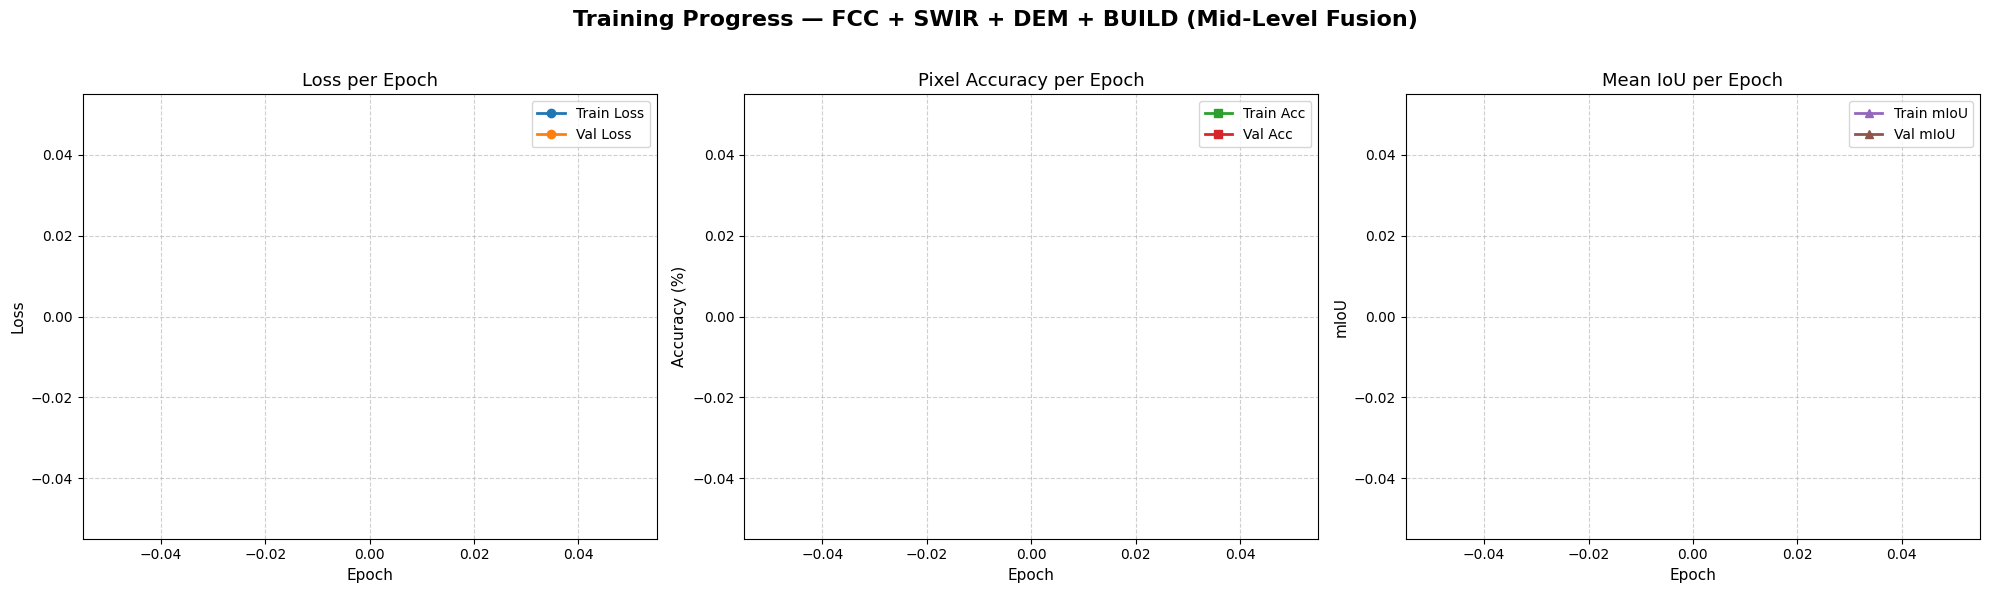

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------
# Enhanced Plot: Training and Validation Curves
# -----------------------------------------

epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(20, 6))
plt.suptitle(
    "Training Progress — FCC + SWIR + DEM + BUILD (Mid-Level Fusion)",
    fontsize=16,
    fontweight='bold'
)

# ===== Loss Curve =====
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss", color="#1f77b4", linewidth=2, marker='o')
plt.plot(epochs, val_losses, label="Val Loss", color="#ff7f0e", linewidth=2, marker='o')
plt.fill_between(epochs, train_losses, val_losses, color="gray", alpha=0.1)
plt.title("Loss per Epoch", fontsize=13)
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# ===== Pixel Accuracy Curve =====
plt.subplot(1, 3, 2)
plt.plot(epochs, [a * 100 for a in train_accs], label="Train Acc", color="#2ca02c", linewidth=2, marker='s')
plt.plot(epochs, [a * 100 for a in val_accs], label="Val Acc", color="#d62728", linewidth=2, marker='s')
plt.title("Pixel Accuracy per Epoch", fontsize=13)
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Accuracy (%)", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# ===== Mean IoU Curve =====
plt.subplot(1, 3, 3)
plt.plot(epochs, train_ious, label="Train mIoU", color="#9467bd", linewidth=2, marker='^')
plt.plot(epochs, val_ious, label="Val mIoU", color="#8c564b", linewidth=2, marker='^')
plt.title("Mean IoU per Epoch", fontsize=13)
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("mIoU", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Calling the trained model

In [ ]:
# from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

# # Path where you saved earlier
# load_dir = "/content/drive/MyDrive/segformer_lulc"

# # Load trained model + processor
# model = SegformerForSemanticSegmentation.from_pretrained(load_dir)
# processor = SegformerFeatureExtractor.from_pretrained(load_dir)

# print("✅ Trained model and processor loaded successfully!")


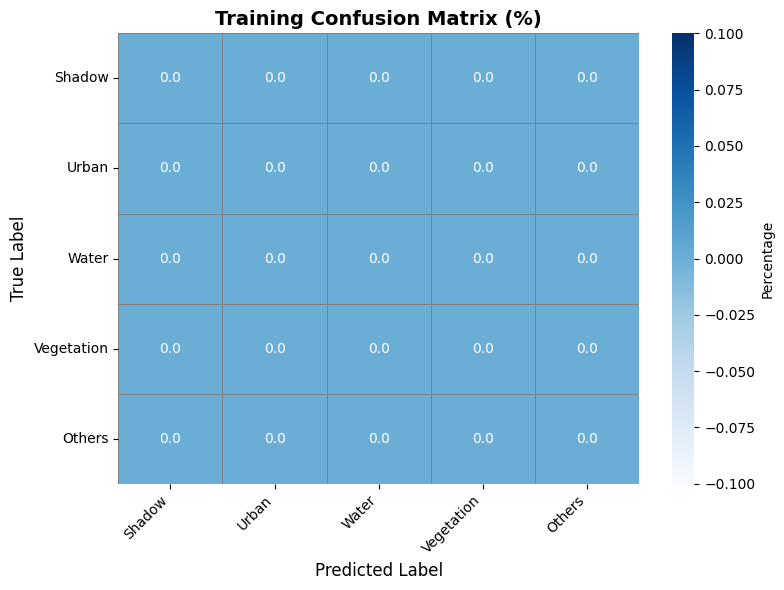

NameError: name 'val_cm' is not defined

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", normalize=True, figsize=(8, 6)):
    """
    Plots a clean, readable confusion matrix with optional normalization.

    Args:
        cm (np.ndarray): Confusion matrix [num_classes, num_classes].
        class_names (list): Class label names.
        title (str): Plot title.
        normalize (bool): Normalize by true class counts if True.
        figsize (tuple): Figure size.
    """
    cm = np.array(cm, dtype=np.float64)

    # Normalize rows (true labels)
    if normalize:
        cm_sum = cm.sum(axis=1, keepdims=True)
        cm = np.divide(cm, cm_sum, where=cm_sum != 0) * 100

    # Formatting values for annotations
    fmt = ".1f" if normalize else "d"
    annot = True

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=annot,
        fmt=fmt,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={"label": "Percentage" if normalize else "Count"},
        linewidths=0.5,
        linecolor="gray"
    )

    plt.title(f"{title} ({'%' if normalize else 'Counts'})", fontsize=14, fontweight='bold')
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# -----------------------------
# Example usage after training
# -----------------------------
class_names = ["Shadow", "Urban", "Water", "Vegetation", "Others"]

# Normalized (percentage)
plot_confusion_matrix(train_cm, class_names, title="Training Confusion Matrix", normalize=True)
plot_confusion_matrix(val_cm, class_names, title="Validation Confusion Matrix", normalize=True)

# Optional raw counts:
# plot_confusion_matrix(val_cm, class_names, title="Validation Confusion Matrix (Counts)", normalize=False)


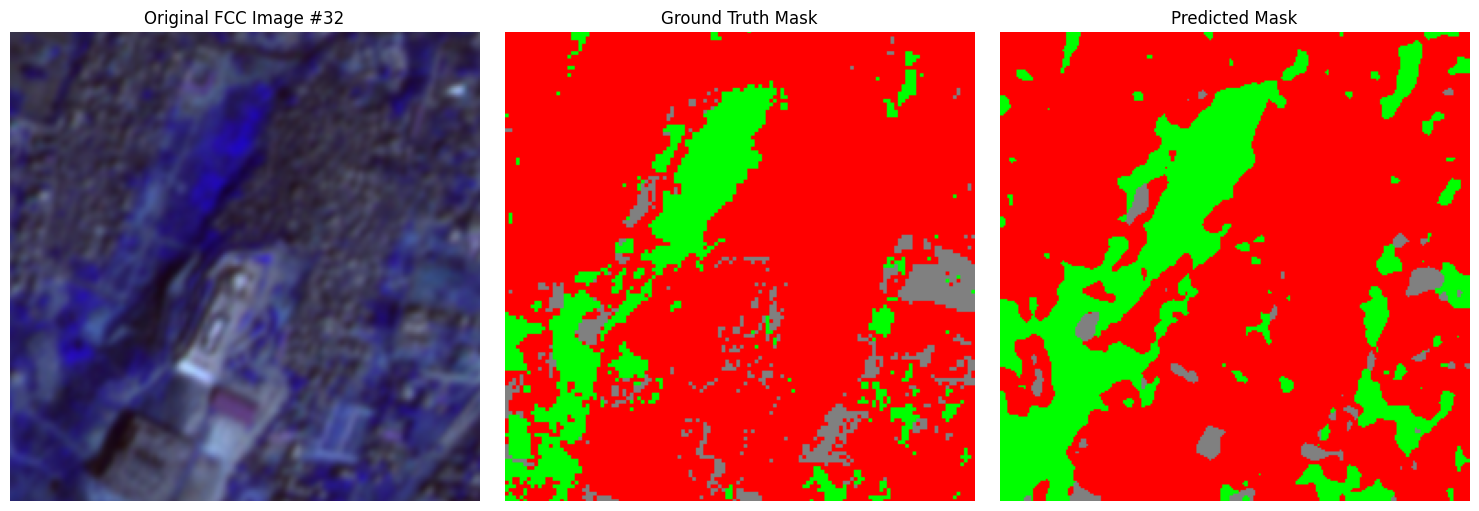

FCC shape: (3, 256, 256), SWIR: torch.Size([3, 256, 256]), DEM: torch.Size([1, 256, 256]), BUILD: torch.Size([1, 256, 256])


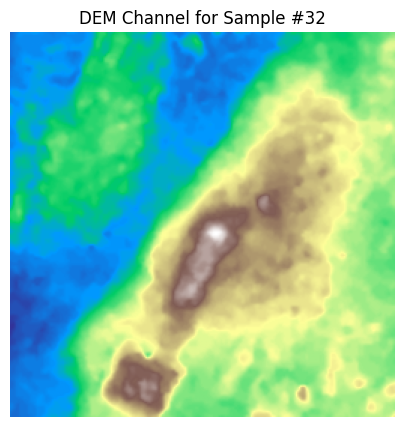

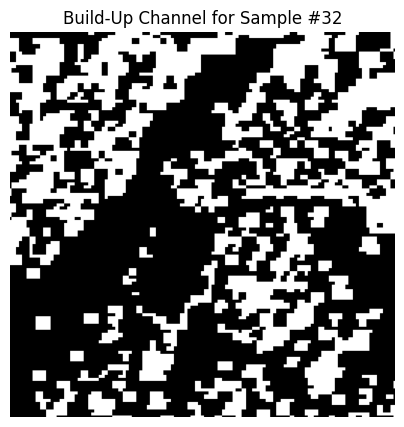

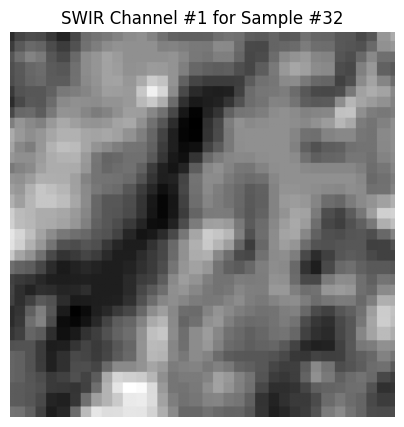

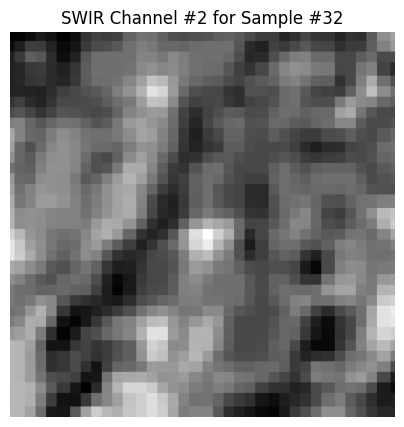

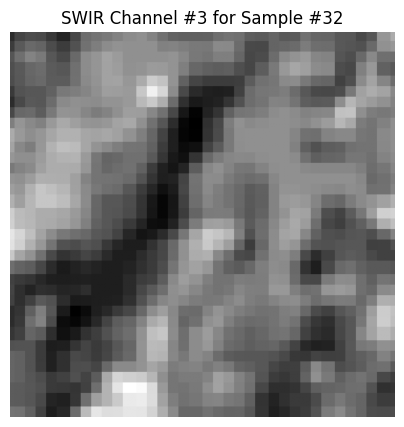

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ======================================
# Color Map for 5 Classes
# ======================================
COLOR_MAP = {
    0: (255, 255,   0),   # Shadow / Barren -> Yellow
    1: (255,   0,   0),   # Urban  -> Red
    2: (  0,   0, 255),   # Water  -> Blue
    3: (  0, 255,   0),   # Vegetation -> Green
    4: (128, 128, 128)    # Others -> Gray
}

def decode_color(mask_np):
    """Convert class indices to RGB image using COLOR_MAP."""
    h, w = mask_np.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in COLOR_MAP.items():
        rgb[mask_np == cls] = color
    return rgb


# ======================================
# Inference on a Validation Sample
# ======================================
model.eval()
idx = 32  # Choose any sample index

# Fetch sample (FCC, SWIR, DEM, BUILD, MASK)
fcc, swir, dem, build, true_mask = val_dataset[idx]
fcc_batch   = fcc.unsqueeze(0).to(device)
swir_batch  = swir.unsqueeze(0).to(device)
dem_batch   = dem.unsqueeze(0).to(device)
build_batch = build.unsqueeze(0).to(device)

# Forward pass
with torch.no_grad():
    outputs = model(fcc_batch, swir_batch, dem_batch, build_batch)
    pred_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()

# ======================================
# Prepare RGB for visualization
# ======================================
fcc_np = fcc.cpu().numpy()
true_mask_np = true_mask.cpu().numpy()

# Undo normalization for FCC
mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
std  = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
img_rgb = (fcc_np[:3] * std + mean).clip(0, 1)
img_rgb = np.transpose(img_rgb, (1, 2, 0))  # CHW -> HWC

# ======================================
# Plot results
# ======================================
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title(f"Original FCC Image #{idx}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(decode_color(true_mask_np))
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(decode_color(pred_mask))
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# ======================================
# Optional: visualize DEM, BUILD, SWIR
# ======================================
print(f"FCC shape: {fcc_np.shape}, SWIR: {swir.shape}, DEM: {dem.shape}, BUILD: {build.shape}")

# DEM
plt.figure(figsize=(5, 5))
plt.imshow(dem.squeeze().cpu(), cmap='terrain')
plt.title(f"DEM Channel for Sample #{idx}")
plt.axis("off")
plt.show()

# BUILD
plt.figure(figsize=(5, 5))
plt.imshow(build.squeeze().cpu(), cmap='gray')
plt.title(f"Build-Up Channel for Sample #{idx}")
plt.axis("off")
plt.show()

# SWIR Channels
for j in range(swir.shape[0]):
    plt.figure(figsize=(5, 5))
    plt.imshow(swir[j].cpu(), cmap='gray')
    plt.title(f"SWIR Channel #{j+1} for Sample #{idx}")
    plt.axis("off")
    plt.show()


In [ ]:
save_dir = "/content/drive/MyDrive/3.0_Seg2.0_FCC+SWIR30E"

import os
import torch
os.makedirs(save_dir, exist_ok=True)

# Save trained model state dictionary
torch.save(model.state_dict(), os.path.join(save_dir, 'model_state_dict.pth'))

# The custom model doesn't have a save_pretrained method for the processor.
# If you were using the Hugging Face SegformerForSemanticSegmentation, you would save the processor like this:
# processor.save_pretrained(save_dir)

print(f"✅ Model state dictionary saved to {os.path.join(save_dir, 'model_state_dict.pth')}")

✅ Model state dictionary saved to /content/drive/MyDrive/3.0_Seg2.0_FCC+SWIR30E/model_state_dict.pth
